In [1]:
import numpy as np
from matplotlib import colors
from matplotlib import cm
from matplotlib import pyplot as plt
import pickle
import signac as sg
from scipy.special import gamma
import copy as copy
import scipy
from project import adjustmaps
import h5py
from scipy.interpolate import make_lsq_spline
from itertools import product

[Patricks-Mini.search.charter.net:62452] shmem: mmap: an error occurred while determining whether or not /var/folders/cs/tn4zg_3d3zq1k5vgjm1ty_vc0000gn/T//ompi.Patricks-Mini.501/jf.0/759627776/sm_segment.Patricks-Mini.501.2d470000.0 could be created.


In [2]:
from matplotlib import rc

# Update global parameters
rc('axes', labelsize=16)  # Font size for x and y labels
rc('xtick', labelsize=15)  # Font size for x-axis tick labels
rc('ytick', labelsize=15)  # Font size for y-axis tick labels
rc('lines', markersize=12)  # Set the default marker size to 10 points
rc('legend', fontsize=14)

In [3]:
metric = "P_s"
metric_lab = '$<P_s>_{meta}$'
Aeff = 1.0
t_final = 600
fn_prefix = f"data/Aeff_{Aeff}/tfinal_{t_final}/metric_{metric}/"
with open(fn_prefix + 'metric_data.pkl', 'rb') as handle:
    metric_data = pickle.load(handle)
with sg.H5Store('shared_data.h5').open(mode='r') as sd:
    b_vec = np.array(sd['b_vec'])
c = 1.42
tau_vec = b_vec * gamma(1+1/c)
tau_step = np.diff(tau_vec)[0] / 2
tau_edges = np.concatenate(([0], np.arange(tau_step/2, tau_vec[-1]+tau_step, tau_step)))
all_tau = np.load('data/Aeff_1.0/tfinal_600/all_tau.npy')
all_metric = metric_data['all_metric']

C_vec = np.load(fn_prefix + "C_vec.npy")
ncell_tot = 87_993
ncell_vec = np.load(fn_prefix + "ncell_vec.npy")
slice_left_all = np.load(fn_prefix + "slice_left_all.npy")
tauc_methods = ["flat"]
eps_axes = {}
with h5py.File(fn_prefix + "/eps_axes.h5", "r") as handle:
    for key in handle.keys():
        eps_axes.update({key: handle[key][()]})

### $\text{max}(\omega)$ vs target $<\text{metric}_{meta}>$

In [4]:
# Collect <metric> across all state variables and uncertainty parameterizations
shape = [len(eps_axes[key]) for key in eps_axes.keys()] 
shape += [len(C_vec), len(ncell_vec), len(slice_left_all)]
phase_full = np.ones((shape)) * np.nan
with h5py.File(fn_prefix + "/phase_flat.h5", "r") as phase_handle:
    for eps_params in product(*eps_axes.values()):
        # Create a dictionary of indices along with values for the current combination
        eps_params_dict = {
            key: (index, np.round(value, 3)) for key, values in zip(eps_axes.keys(), eps_axes.values())
            for index, value in enumerate(values) if value == eps_params[list(eps_axes.keys()).index(key)]
        }
        
        # Get phase slice at this epsilon parameterization
        data_key = f"{eps_params_dict['mu_tau'][1]}/{eps_params_dict['sigm_tau'][1]}/"
        data_key += f"{eps_params_dict['mu_tauc'][1]}/{eps_params_dict['sigm_tauc'][1]}/phase"
        phase_slice = phase_handle[data_key][:]
        
        # Add them to collective phase_all
        eps_indices = [val[0] for val in eps_params_dict.values()]
        index_tuple = tuple(eps_indices) + (slice(None), slice(None), slice(None))
        phase_full[index_tuple] = phase_slice

rob_thresh_vec = np.linspace(min(phase_full.flatten()), max(phase_full.flatten()), 100)
allrob = np.ones((rob_thresh_vec.size, C_vec.size, ncell_vec.size, slice_left_all.size)) * np.nan
maxrob = np.ones((len(rob_thresh_vec), len(C_vec))) * np.nan
argmaxrob = np.ones((len(rob_thresh_vec), len(C_vec), 2)) * np.nan
tot_eps_samples = np.cumprod([len(axis) for axis in eps_axes.values()])[-1]
zero_eps_i = [np.argwhere(ax == 0)[0][0] for ax in eps_axes.values()]
for (thresh_i, thresh), (C_i, C) in product(enumerate(rob_thresh_vec), 
                                            enumerate(C_vec)):
    rob_slice = np.ones((len(ncell_vec), len(slice_left_all))) * np.nan
    for (ncell_i, ncell), (sl_i, sl) in product(enumerate(ncell_vec),
                                                enumerate(slice_left_all)):
        # First, check that this result is feasible with zero uncertainty
        # Skip and keep at nan if not feasible
        metric_zero_eps = phase_full[tuple(zero_eps_i + [C_i, ncell_i, sl_i])]
        if np.isnan(metric_zero_eps) or (metric_zero_eps < thresh): continue
        # Now, get the robstness at this (C,ncell,slice_left) coordinate and store
        counts = np.count_nonzero(phase_full[..., C_i, ncell_i, sl_i] >= thresh)
        robustness = counts / tot_eps_samples
        rob_slice[ncell_i, sl_i] = robustness
    allrob[thresh_i, C_i] = rob_slice
    if np.any(~np.isnan(rob_slice)):
        # Store the max robustness at this (thresh, C) coordinate
        maxrob[thresh_i, C_i] = np.nanmax(rob_slice)
        # Also store the optimal param indices
        optimal_param_i = np.unravel_index(np.nanargmax(rob_slice, axis=None), rob_slice.shape)
        argmaxrob[thresh_i, C_i] = optimal_param_i

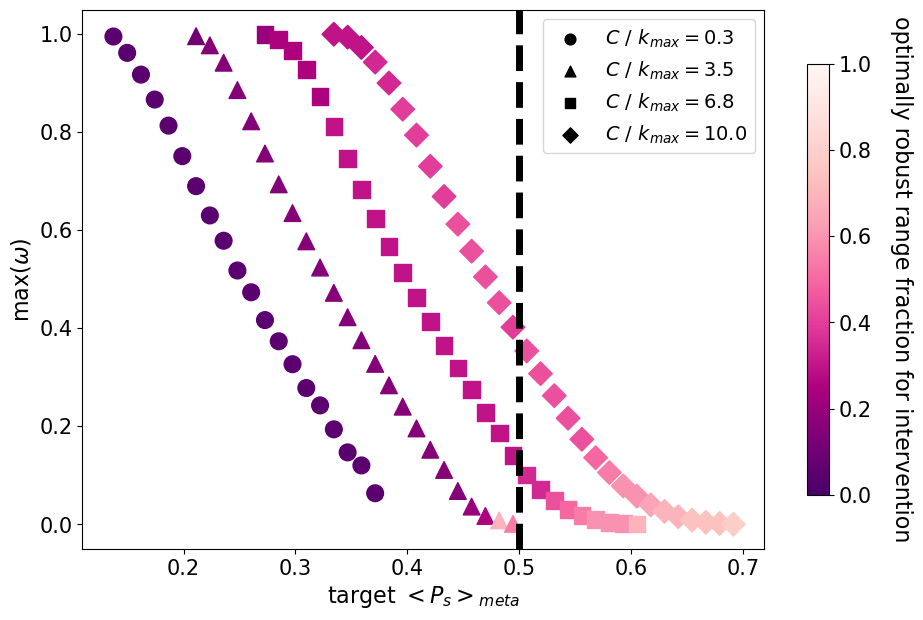

In [5]:
fig, ax = plt.subplots(1, figsize=(11,7))
colormap = copy.copy(cm.RdPu_r)
vmax = 1; vmin = 0
normalize = colors.Normalize(vmin=vmin, vmax=vmax)
# colors = colormap(normalize(ncell_vec))

all_markers = ['o','^','s','D']
all_linestyles = ['dotted', 'dashdot', 'dashed', 'solid']
C_i_samples = [0,3,6,9]
# C_i_samples = [9]
for line_i, C_i in enumerate(C_i_samples):
    plot_vec = np.ones(len(rob_thresh_vec)) * np.nan
    c_vec = np.ones(len(rob_thresh_vec)) * np.nan
    for thresh_i, thresh in enumerate(rob_thresh_vec):
        if thresh_i % 2 == 0: continue
        # Get the maximum robustness across (ncell, sl) at this C 
        if maxrob[thresh_i, C_i] < 1:
            plot_vec[thresh_i] = maxrob[thresh_i, C_i]
        if not np.isnan(plot_vec[thresh_i]):
            c_vec[thresh_i] = ncell_vec[int(argmaxrob[thresh_i, C_i][0])] / ncell_tot
    scatter = ax.scatter(rob_thresh_vec, plot_vec, cmap=colormap, norm=normalize,
                        c=c_vec, marker=all_markers[line_i])#, s=60)
    ax.scatter([], [], label=fr"$C~/~k_{{max}}=${np.round(C_vec[C_i]/ncell_tot, 1)}", 
               s=60, c='black', marker=all_markers[line_i])
cbar = fig.colorbar(scatter, ax=ax, location="right", shrink=0.8)
cbar.set_label(fr"optimally robust range fraction for intervention", rotation=-90, labelpad=30)
ax.set_ylabel(fr"$\text{{max}}(\omega)$")
ax.set_xlabel(fr"target {metric_lab}")
ax.legend()
ax.axvline(0.5, ls='--', c='k', lw=5)
fn = f"figs/Aeff_{Aeff}/tfinal_{t_final}/metric_{metric}/maxrob.png"
fig.savefig(fn, bbox_inches='tight')

### $\text{max}(<\text{metric}_{meta}>$ under $\epsilon=0$

In [6]:
with h5py.File(fn_prefix + "/phase_flat.h5", "r") as phase_handle:
    data_key = "0.0/0.0/0.0/0.0/phase"
    phase_slice_zeroeps = phase_handle[data_key][:]
    nochange_zeroeps = phase_handle["0.0/0.0/0.0/0.0/metric_nochange"][()]

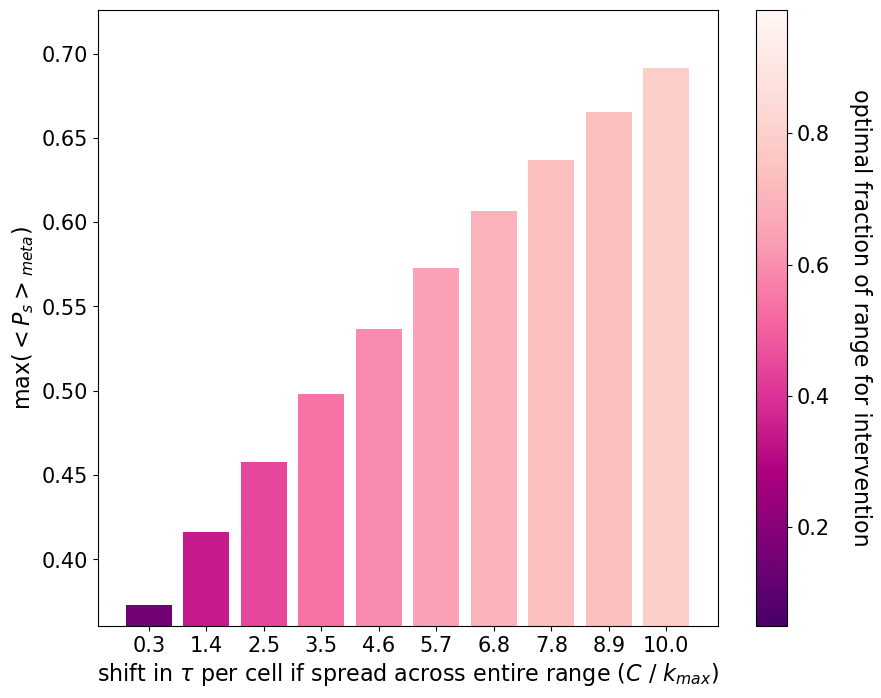

In [7]:
fig, ax = plt.subplots(1, figsize=(10,8))

plot_vec = np.ones_like(C_vec) * np.nan
c_vec = np.ones_like(C_vec) * np.nan
for C_i, C in enumerate(C_vec):
    argmax = np.nanargmax(phase_slice_zeroeps[C_i, :, :])
    optimal_param_i = np.unravel_index(argmax, phase_slice_zeroeps.shape[1:])
    # print(C_i, optimal_param_i)
    plot_vec[C_i] = phase_slice_zeroeps[C_i, optimal_param_i[0], optimal_param_i[1]]
    c_vec[C_i] = ncell_vec[optimal_param_i[0]]
c_vec = c_vec / ncell_tot
vmax = np.nanmax(c_vec); vmin = np.nanmin(c_vec)
vmin = 0; vmax = 1
vmin = min(ncell_vec) / ncell_tot; vmax = max(ncell_vec) / ncell_tot
norm = colors.Normalize(vmin=vmin, vmax=vmax)
colormap = copy.copy(cm.RdPu_r)
sm = cm.ScalarMappable(cmap=colormap, norm=norm)
bar_colors = colormap(norm(c_vec))
bar = ax.bar(np.arange(C_vec.size), plot_vec, color=bar_colors)
cbar = plt.colorbar(sm, label='Color Scale Value', ax=ax)
cbar.set_label(fr"optimal fraction of range for intervention", rotation=-90, labelpad=30)
ax.set_ylim(nochange_zeroeps, 1.05*np.max(plot_vec))
ax.set_ylabel(fr"$\text{{max}}(${metric_lab}$)$")
xtick_spacing = 1
xticks = np.arange(0, len(C_vec), xtick_spacing)
ax.set_xticks(xticks, labels=np.round((C_vec/(ncell_tot))[::xtick_spacing], 1));
ax.set_xlabel(r"shift in $\tau$ per cell if spread across entire range $({C}~/~{k_{max}})$")

fn = f"figs/Aeff_{Aeff}/tfinal_{t_final}/metric_{metric}/maxmetric_C_zeroeps.png"
fig.savefig(fn, bbox_inches='tight')

### Visualize fire regime change

In [8]:
# Get histogram of <metric> over all cells based on above spl
ul_coord = [1500, 2800]
lr_coord = [2723, 3905]
usecols = np.arange(ul_coord[0],lr_coord[0])
sdmfn = "../shared_maps/SDM_1995.asc"
sdm = np.loadtxt(sdmfn,skiprows=6+ul_coord[1],
                         max_rows=lr_coord[1], usecols=usecols)
fdmfn = '../shared_maps/FDE_current_allregions.asc'
fdm = np.loadtxt(fdmfn,skiprows=6+ul_coord[1], 
                         max_rows=lr_coord[1], usecols=usecols)
sdm, fdm = adjustmaps([sdm, fdm])
delta_t = 30
b_raster = delta_t / np.power(-np.log(1-fdm), 1/c)
tau_raster = b_raster * gamma(1+1/c)
maps_filt = (sdm > 0) & (fdm > 0)
tau_flat = tau_raster[maps_filt] #+ (max(C_vec)/ncell_tot)
tau_flat[tau_flat > max(tau_vec)] = max(tau_vec)
tau_argsort = np.argsort(tau_flat)

/var/folders/cs/tn4zg_3d3zq1k5vgjm1ty_vc0000gn/T/ipykernel_62452/4008709933.py:13: RuntimeWarning: divide by zero encountered in divide
  b_raster = delta_t / np.power(-np.log(1-fdm), 1/c)


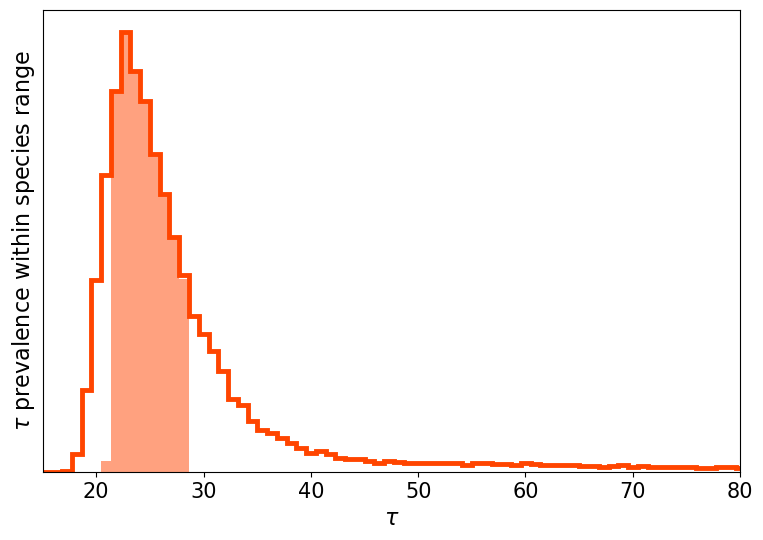

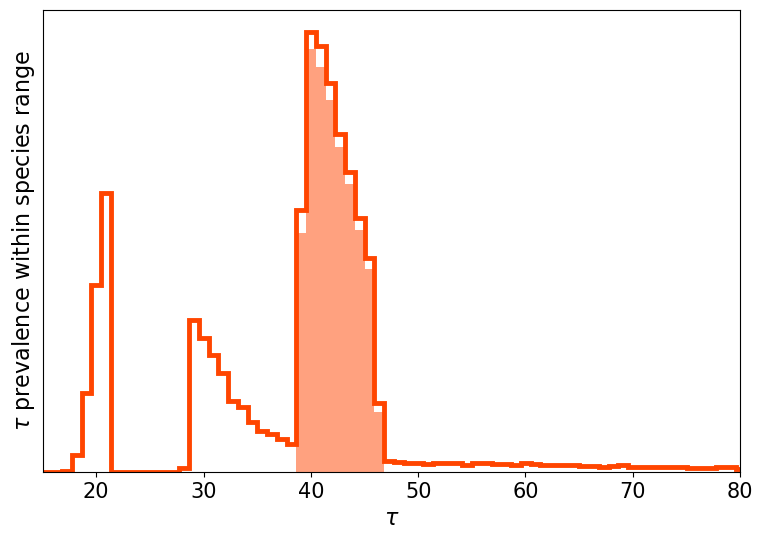

In [9]:
figsize = (9,6)
fig, ax = plt.subplots(1, figsize=figsize)
tau_max = 80
color = 'orangered'
tau_step = np.diff(tau_vec)[0] / 2
tau_edges = np.concatenate(([0], np.arange(tau_step/2, tau_vec[-1]+tau_step, tau_step)))
ax.hist(tau_flat, bins=tau_edges, color=color, histtype='step', lw=3.5); 
ncell = 50_000
# ncell = 19_000
sl = 11_000
tau_slice = tau_flat[tau_argsort][sl:sl+ncell]
ax.hist(tau_slice, bins=tau_edges, color=color, alpha=0.5);
ax.set_yticks([])
ax.set_ylabel(r"$\tau$ prevalence within species range")
ax.set_xlabel(r"$\tau$")
ax.set_xlim(15, tau_max);
# fn = f"figs/Aeff_{Aeff}/tfinal_{t_final}/metric_{metric}/maxmetric_C_zeroeps.png"
fn = f"figs/taudist_preshift_{ncell}.png"
fig.savefig(fn, bbox_inches='tight')

fig, ax = plt.subplots(1, figsize=figsize)
tauc = max(C_vec) / ncell
tau_shifted = tau_flat[tau_argsort].copy()
tau_shifted[sl:sl+ncell] += tauc
ax.hist(tau_shifted, bins=tau_edges, color=color, histtype='step', lw=3.5); 
ax.hist(tau_slice+tauc, bins=tau_edges, color=color, alpha=0.5);
ax.set_yticks([])
ax.set_ylabel(r"$\tau$ prevalence within species range")
ax.set_xlabel(r"$\tau$")
ax.set_xlim(15, tau_max);
fn = f"figs/taudist_postshift_{ncell}.png"
fig.savefig(fn, bbox_inches='tight')

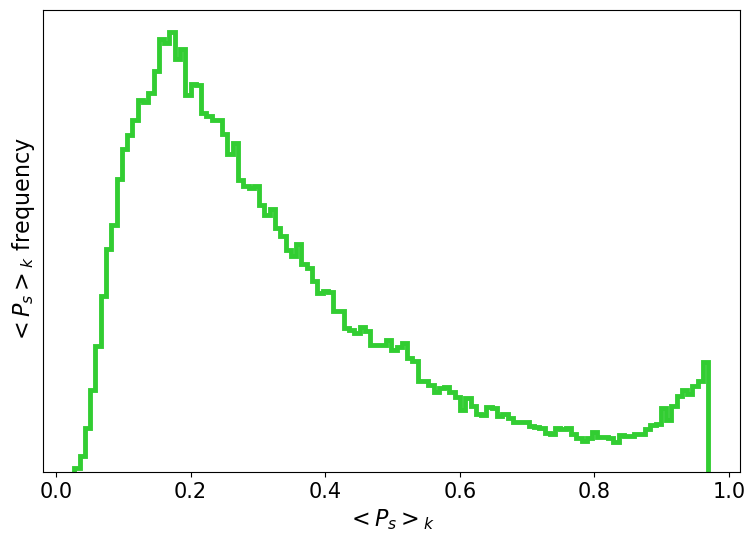

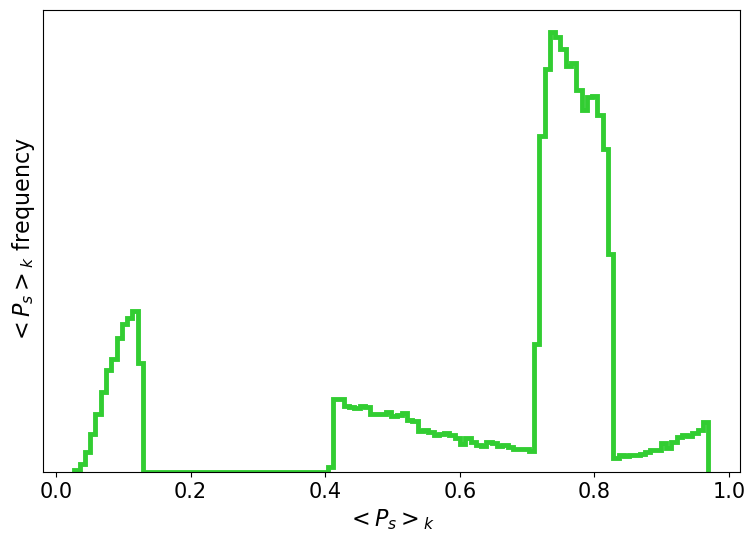

In [10]:
# Make Bspline interpolation for <metric>
metric_expect_vec = np.ones(tau_vec.size) * np.nan
for tau_i, tau in enumerate(tau_vec):
    tau_filt = (all_tau == tau)
    metric_slice = all_metric[tau_filt]
    metric_expect_vec[tau_i] = np.mean(metric_slice)
t = tau_vec[2:-2:1] 
k = 3
t = np.r_[(0,)*(k+1), t, (tau_vec[-1],)*(k+1)]
spl = make_lsq_spline(tau_vec[1:], metric_expect_vec[1:], t, k)

# Vizualise distribution of $<\text{metric}>$
figsize = (9,6)
fig, ax = plt.subplots(1, figsize=figsize)
color = 'limegreen'
mlab = "$<P_s>_k$"
ax.hist(spl(tau_flat[tau_flat < tau_max]), bins=120, color=color, histtype='step', lw=3.5); 
ax.set_yticks([])
ax.set_ylabel(rf"{mlab} frequency")
ax.set_xlabel(rf"{mlab}")
fn = f"figs/Aeff_{Aeff}/tfinal_{t_final}/metric_{metric}/metricdist_preshift_{ncell}.png"
fig.savefig(fn, bbox_inches='tight')

fig, ax = plt.subplots(1, figsize=figsize)
ax.hist(spl(tau_shifted[tau_shifted < tau_max]), bins=120, color=color, histtype='step', lw=3.5); 
ax.set_yticks([])
ax.set_ylabel(rf"{mlab} frequency")
ax.set_xlabel(rf"{mlab}")
fn = f"figs/Aeff_{Aeff}/tfinal_{t_final}/metric_{metric}/metricdist_postshift_{ncell}.png"
fig.savefig(fn, bbox_inches='tight')

### Map change optimizing $\omega$ instead of $<\text{metric}>_\text{meta}$

In [11]:
mapindices = np.argwhere(maps_filt)
C_i = 9

flat = phase_slice_zeroeps[C_i].ravel()
non_nan_i = np.where(~np.isnan(flat))[0]
flat_sort = non_nan_i[np.argsort(flat[non_nan_i])]
phase_sorted_i = np.unravel_index(flat_sort, phase_slice_zeroeps[C_i].shape)
phase_sorted_i = list((zip(phase_sorted_i[0], phase_sorted_i[1])))
tot_samples = len(phase_sorted_i)
num_samples = int(tot_samples * 0.025)
tot_tauc_k = np.zeros(maps_filt.shape)
n_k = np.zeros(maps_filt.shape)
tauc_relative = np.zeros(maps_filt.shape)
for i in range(tot_samples - num_samples, tot_samples):
    ncell = ncell_vec[phase_sorted_i[i][0]]
    sl = slice_left_all[phase_sorted_i[i][1]]
    map_slice = mapindices[tau_argsort][sl:sl+ncell]
    for map_i in map_slice:
        tot_tauc_k[map_i[0],map_i[1]] += (C_vec[C_i] / ncell)
        n_k[map_i[0],map_i[1]] += 1
        tauc_relative[map_i[0],map_i[1]] += (C_vec[C_i] / ncell) / tau_raster[map_i[0],map_i[1]]
avg_tauc_k = tot_tauc_k / n_k
tauc_relative = tauc_relative / n_k

target = 0.5
target_i = np.argmin(np.abs(rob_thresh_vec - target))
target = rob_thresh_vec[target_i]
flat = allrob[target_i, C_i].ravel()
non_nan_i = np.where(~np.isnan(flat))[0]
flat_sort = non_nan_i[np.argsort(flat[non_nan_i])]
rob_sorted_i = np.unravel_index(flat_sort, allrob[target_i, C_i].shape)
rob_sorted_i = list((zip(rob_sorted_i[0], rob_sorted_i[1])))
tot_samples = len(rob_sorted_i)
num_samples = int(tot_samples * 0.04)
print(num_samples)
tot_tauc_k_rob = np.zeros(maps_filt.shape)
n_k_rob = np.zeros(maps_filt.shape)
tauc_relative_rob = np.zeros(maps_filt.shape)
for i in range(tot_samples - num_samples, tot_samples):
    ncell = ncell_vec[rob_sorted_i[i][0]]
    sl = slice_left_all[rob_sorted_i[i][1]]
    map_slice = mapindices[tau_argsort][sl:sl+ncell]
    for map_i in map_slice:
        tot_tauc_k_rob[map_i[0],map_i[1]] += (C_vec[C_i] / ncell)
        n_k_rob[map_i[0],map_i[1]] += 1
        tauc_relative_rob[map_i[0],map_i[1]] += (C_vec[C_i] / ncell) / tau_raster[map_i[0],map_i[1]]
avg_tauc_k_rob = tot_tauc_k_rob / n_k_rob
tauc_relative_rob = tauc_relative_rob / n_k_rob

/var/folders/cs/tn4zg_3d3zq1k5vgjm1ty_vc0000gn/T/ipykernel_62452/3744372665.py:22: RuntimeWarning: invalid value encountered in divide
  avg_tauc_k = tot_tauc_k / n_k
/var/folders/cs/tn4zg_3d3zq1k5vgjm1ty_vc0000gn/T/ipykernel_62452/3744372665.py:23: RuntimeWarning: invalid value encountered in divide
  tauc_relative = tauc_relative / n_k


10


/var/folders/cs/tn4zg_3d3zq1k5vgjm1ty_vc0000gn/T/ipykernel_62452/3744372665.py:47: RuntimeWarning: invalid value encountered in divide
  avg_tauc_k_rob = tot_tauc_k_rob / n_k_rob
/var/folders/cs/tn4zg_3d3zq1k5vgjm1ty_vc0000gn/T/ipykernel_62452/3744372665.py:48: RuntimeWarning: invalid value encountered in divide
  tauc_relative_rob = tauc_relative_rob / n_k_rob


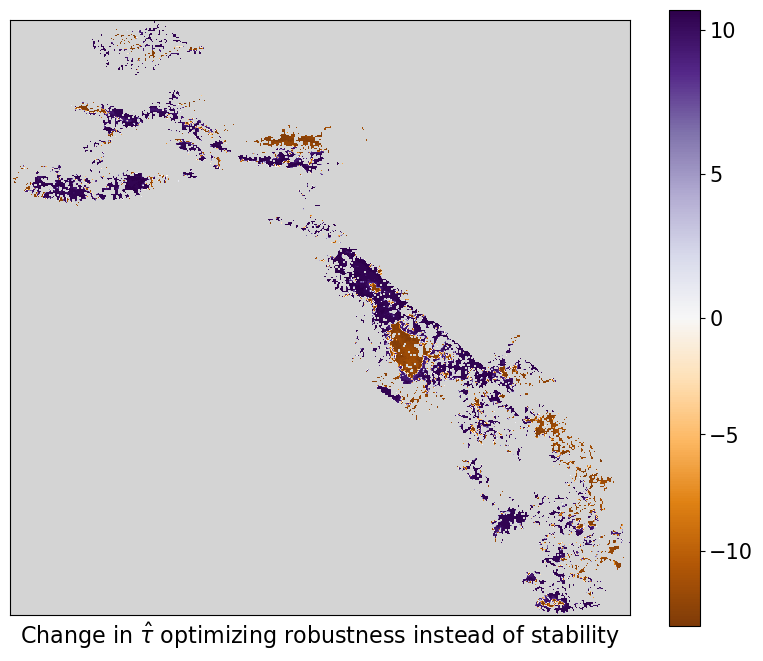

In [12]:
fig, ax = plt.subplots(1, figsize=(10,10))

imshow_mat = np.where(np.isnan(avg_tauc_k_rob), 0, avg_tauc_k_rob) - np.where(np.isnan(avg_tauc_k), 0, avg_tauc_k)
imshow_mat[imshow_mat == 0] = np.nan
nonzero_indices = np.nonzero(~np.isnan(imshow_mat))
row_min, row_max = nonzero_indices[0].min(), nonzero_indices[0].max()
col_min, col_max = nonzero_indices[1].min(), nonzero_indices[1].max()
imshow_mat = imshow_mat[row_min:row_max + 1, col_min:col_max + 1]

vmin = np.nanmin(imshow_mat); vmax = np.nanmax(imshow_mat)
center = 0
cmap = cm.PuOr.copy()
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=center, vmax=vmax)
cmap.set_bad(color='darkgrey', alpha=0.5)
imshow = ax.imshow(imshow_mat, cmap=cmap, norm=norm)
cbar = fig.colorbar(imshow, ax=ax, location="right", shrink=0.8)
ax.set_xlabel(fr"Change in $\hat{{\tau}}$ optimizing robustness instead of stability")
ax.set_xticks([])
ax.set_yticks([])
fn = f"figs/Aeff_{Aeff}/tfinal_{t_final}/metric_{metric}/map_example.png"
fig.savefig(fn, bbox_inches='tight')

### Visualize $P(\text{metric}|\tau)$

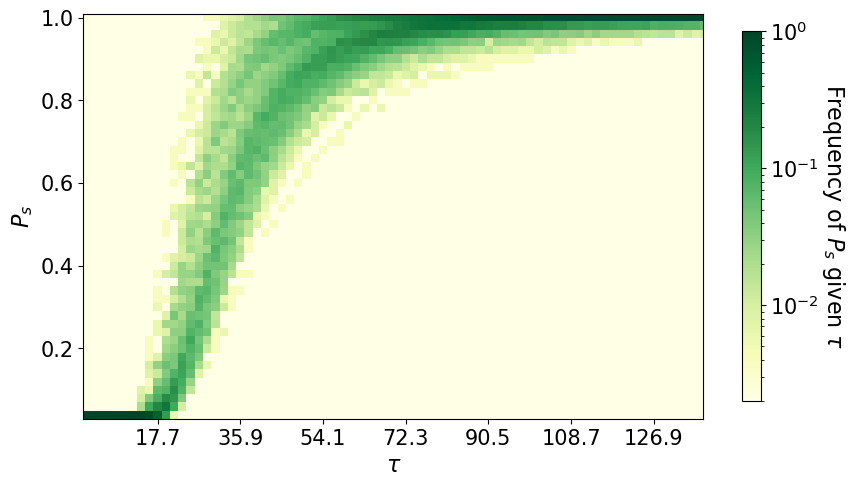

In [13]:
metric_edges = np.linspace(0, 1, 50)
metric_hist = np.histogram2d(all_tau, all_metric, bins=[tau_edges[::2], metric_edges], density=False)
fig, ax = plt.subplots(figsize=(10,8))
cmap = copy.copy(cm.YlGn)
cmap.set_bad(cmap(0.0))
imshow_mat = np.flip(np.transpose(metric_hist[0]), axis=0)
samples_per_tau = int(len(all_metric)/len(b_vec))
imshow_mat = imshow_mat / samples_per_tau
smoothed = scipy.ndimage.gaussian_filter(imshow_mat, sigma=0.125)
im = ax.imshow(imshow_mat, cmap=cmap,
              norm=colors.LogNorm(vmax=1), interpolation="nearest")
cbar = ax.figure.colorbar(im, ax=ax, location="right", shrink=0.6)
cbar.ax.set_ylabel(rf'Frequency of $P_s$ given ${{\tau}}$', 
                   rotation=-90, labelpad=20)
ytick_spacing = 10
ytick_labels = np.flip(metric_hist[2])[::ytick_spacing]
yticks = np.arange(0,len(metric_hist[2]),ytick_spacing)
ax.set_yticks(yticks, labels=np.round(ytick_labels, decimals=1));
ax.set_ylabel(rf'$P_s$')
xtick_spacing = 10
xtick_labels = np.round(metric_hist[1][::xtick_spacing],1)
xticks = np.arange(0,len(metric_hist[1]),xtick_spacing)
ax.set_xticks(xticks, labels=xtick_labels);
ax.set_xlabel(r'$\tau$')
ax.set_xlim(1, imshow_mat.shape[1]-1)
fn = f"figs/Aeff_{Aeff}/tfinal_{t_final}/metric_{metric}/Pmetric_given_tau.png"
fig.savefig(fn, bbox_inches='tight')